# Advanced RAG on HuggingFace documentation using langchain

This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user's question about a specific knowledge base (here, the HuggingFace documentation), using LangChain.

RAG systems have plentiful options for improvement: we will see how you can tune your system along the way to improve results beyond a baseline model.

# What is RAG?

When using a Large Language Model (LLM) to answer questions about a particular field of knowledge, two issues may appear:
- the LLM not having knowledge of domain-specific information due to it not being available in its training data
- the risk of hallucination: when asked to give an answer on an unknown field, the LLM may hallucinate a credible answer.

These two problems can be tempered by fine-tuning the LLM on the said field of knowledge
However, fine-tuning can be costly, and, when done repeatedly (e.g. to address changes in data), leads to "model shift" _(this is when the model's behavior changes in ways that are not desirable)_.

RAG (Retrieval Augmented Generation) does not require model fine-tuning. Instead, RAG works by enhancing an LLM with access to additional context retrieved from relevant data, so that it can generate a better-informed response.

RAG systems consists of two subsystems:

1. A Retriever system, functioning like an internal search engine, identifies the most relevant documents from the knowledge base to respond to the query.
2. A Reader Language Model (LLM) reads these retrieved documents to produce an answer to the user’s query.

Here is the workflow, with paths for system tuning noted in blue:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_graph.png" height="700">


> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

__Let's dig into the model building!__ First, we install the required model dependancies.

In [1]:
!pip install -q torch transformers transformers langchain sentence-transformers faiss-gpu openpyxl openai


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
%reload_ext dotenv
%dotenv

In [6]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # this will be helpful when visualizing retriever outputs

### Load your knowledge base

In [7]:
import datasets

ds = datasets.load_dataset("A-Roucher/huggingface_doc", split="train")

# 1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns the `top_k` most relevant snippets from your knowledge base.

> For the knowledge base, we use Langchain vector databases since __it offers a convenient [FAISS](https://github.com/facebookresearch/faiss) index and allows us to keep document metadata throughout the processing__.

### 1.1 Split the documents into chunks

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to have semantically relevant snippets: not too small to be sufficient for supporting an answer, and not too large too avoid diluting each idea.

> We use Langchain's `RecursiveCharacterTextSplitter`, which makes efficient use of code language detection to make better splits.

The parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.

In [9]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [36]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

Now we have to keep in mind that when embeddding documents, we will use an embedding model that has accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit, because any longer chunk will be truncated before processing, thus losing relevancy.

Model's maximum sequence length: 512


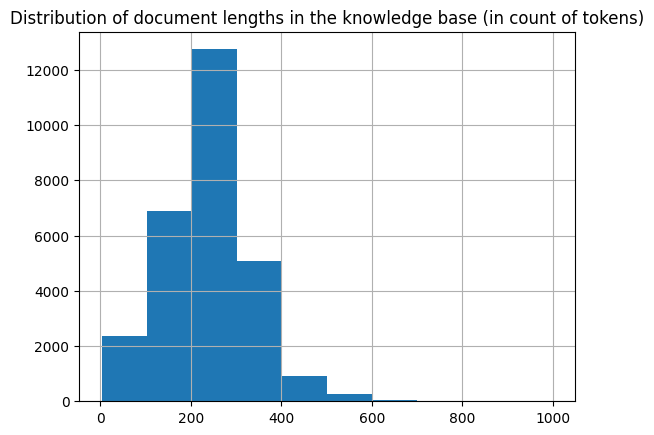

In [34]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('thenlper/gte-small').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in docs_processed]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

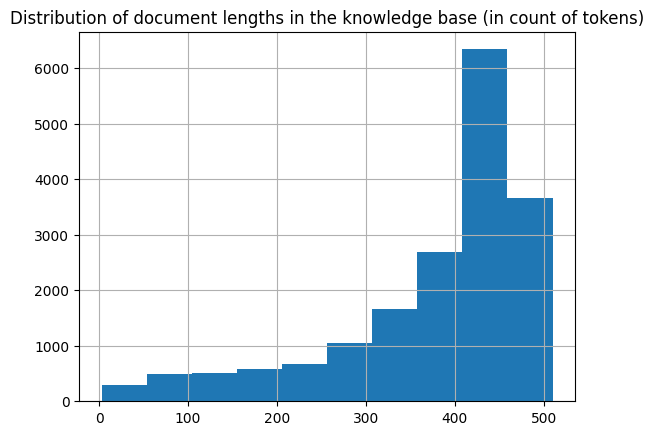

In [39]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=["\n\n", "\n", ".", " ", ""],
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    return docs_processed


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

💡 To help you tune this step, [this space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different chunking options affect the chunks you get.

https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/embeddings/huggingface.py#L232

### 1.2 Building the vector database

Now we compute the embeddings for all the chunks of our knowledge base: we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/) about sentence embeddings.

Once the chunks are all embedded, we store them into a vector database. There are many choices here for the database, depending on the search strategy to use. We go with Facebook's [FAISS](https://github.com/facebookresearch/faiss).

Our particular model works well with [Cosine similarity](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings), so we use this distance both in the Embedding model, and in the `distance_strategy` argument of our FAISS index.

⬇️🚨 The cell below takes a few minutes to run on A10G!

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

KNOWLEDGE_INDEX = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

### 1.3 Setup the Retriever
- When the vector database is built, the retriever works by embedding the user query and searching for the top `k` most similar documents in the vector database.
- Here, this operation is transparently performed by the method `KNOWLEDGE_INDEX.similarity_search(query)`

In [124]:
print("\nStarting retrieval...")
retrieved_docs = KNOWLEDGE_INDEX.similarity_search(
    query="How to create a pipeline object?", k=5
)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval...

==================================Top document==================================
!--Copyright 2020 The HuggingFace Team. All rights reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with
the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on
an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the

⚠️ Note that this file is in Markdown but contain specific syntax for our doc-builder (similar to MDX) that may not be
rendered properly in your Markdown viewer.

-->

# How to create a custom pipeline?

In this guide, we will see how to create a custom pipeline and share it on the [Hub](hf.co/models) or add it to the
🤗 Transformers library.

First and foremost, you need to decide the

## 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are actually substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt then given to the LLM to generate its answer.

### Reader model

The choice of a reader model is important on a few aspects:
- the reader model's `max_seq_length` must accomodate our prompt, which includes the context output by the retriever call: the context consists in 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

In [103]:
from transformers import pipeline

READER_MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

READER_LLM = pipeline("text-generation", model=READER_MODEL_NAME, max_new_tokens=500)


# Since we only want to get the outputs and not the prompt + outputs, we use a new method removing the prompt from the llm outputs
def invoke_llm(prompt: str) -> str:
    return READER_LLM(prompt)[0]["generated_text"][len(prompt) :]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

In [107]:
RAG_PROMPT_TEMPLATE = """
<|system|>
Using the information contained in the context, 
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
</s>
<|assistant|>
"""

Let's test our Reader on our previously retrieved documents!

In [125]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = invoke_llm(final_prompt)
print(answer)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


To create a pipeline object, you first need to import the `pipeline` function from the `transformers` library. Then, you can create a pipeline instance by passing the model name or path to the `pipeline` function. For example:

```python
from transformers import pipeline
pipe = pipeline("model_name_or_path")
```

Replace "model_name_or_path" with the name or path of the model you want to use. The pipeline object will be able to perform inference on the input data using the specified model.

If you want to specify additional arguments like the device to run the pipeline on, you can pass them as keyword arguments. For example:

```python
pipe = pipeline("model_name_or_path", device="cuda:0")
```

This will create a pipeline object that runs the inference on the CUDA device with index 0.

Please note that the exact steps to create a pipeline might vary depending on the specific use case and the type of data you want to process (text, image, audio, etc.). The documentation for the specific

# 3. Assembling it all!

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is now easily usable thanks to the library [ragatouille](https://github.com/bclavie/RAGatouille).

In [113]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [127]:
def answer_with_rag(
    question: str,
    call_llm,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = call_llm(final_prompt)

    return answer, relevant_docs

## Test
Let's see how our RAG pipeline answers a user query.

In [128]:
question = "how to create a pipeline object?"


answer, relevant_docs = answer_with_rag(
    question, invoke_llm, KNOWLEDGE_INDEX, reranker=RERANKER
)

=> Retrieving documents...


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


=> Reranking documents...
WARNING! Your documents have duplicate entries!  This will slow down calculation and may yield subpar results
=> Generating answer...


In [129]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for a vision task, you can use the `pipeline` function from the `transformers` library, and specify the task as an argument. For example, to create a pipeline for object detection, you can use:

```python
>>> pipeline = pipeline('object-detection')
```

You can then use this pipeline to make predictions on images. For example:

```python
>>> image = cv2.imread('image.jpg')
>>> result = pipeline(images=image)
>>> print(result)
```

This will return a list of detections, each containing the label, score, and bounding box coordinates.

If you want to make predictions on multiple images at once, you can pass them as a list:

```python
>>> images = [cv2.imread('image1.jpg'), cv2.imread('image2.jpg')]
>>> result = pipeline(images=images)
>>> print(result)
```

This will return a list of results, each corresponding to one of the input images.

You can also make predictions on images loaded f

✅ We have a functional RAG sytem. That's it for today! Thank you for following along.


# To go further

This is not the end of the journey! You can try many steps to improve your RAG system. We recommend doing so in an iterative way: brigng small changes to the system and see what improves performance.

### Setting up an evaluation pipeline

- 💬 "What you do not measure, you cannot improve", said Gandhi. Or at least an LLM told me he said it. Anyway, you should absolutely start by measuring performance: this means building a small evaluation dataset, then monitor the performance of your RAG system on this evaluation dataset.

### Improving the retriever

🛠️ __You can use these options to tune the results:__

- Tune the chunking method:
    - Size of the chunks
    - Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker)...
- Change the embedding model

👷‍♀️ __More could be considered:__
- Try another chunking method, like semantic chunking
- Change the index used (here, FAISS)

### Improving the reader

🛠️ __Here you can try the following options to improve results:__
- Switch reranking on/off
- Change the reader model

💡 __Many options could be considered here to further improve the results:__
- Tune the prompt template
- Use a more powerful Reader model
- Compress the retrieved context to keep only the most relevant parts to answer the query.
- Extend the RAG system to make it more user-friendly:
    - cite source
    - make conversational